# **Klasifikasi Gambar Buah**

## **Sumber Dataset**
https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification

- **Nama:** Nabila Neva Rahmawati
- **Email:** nabilanevaaa@gmail.com
- **ID Dicoding:** nabilaneva

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


# **Import Libraries**

In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [4]:
# Upload file kaggle.json untuk autentikasi
from google.colab import files
files.upload()  # Upload file kaggle.json dari Kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaneva","key":"a2bf5a36173284d034f2e97a666bdf6d"}'}

In [5]:
# Setup API key agar bisa akses Kaggle Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download kaggle dataset dan unzip the file
!kaggle datasets download -d utkarshsaxenadn/fruits-classification
!unzip fruits-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Fruits Classification/train/Grape/Grape (1950).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1952).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1953).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1955).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1956).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1957).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1958).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1959).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (196).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1960).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1961).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1962).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1963).jpeg  
  inflating: Fruits Classification/train/Grape/Grape (1964).jpeg  
  in

## **Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [6]:
# Direktori awal untuk train dan test (setelah unzip)
train_dir = "Fruits Classification/train"
test_dir = "Fruits Classification/test"

# Direktori baru untuk dataset gabungan
combined_dir = "Fruits Classification/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari Training
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari Test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### **Plot Gambar Sampel untuk Semua Kelas**

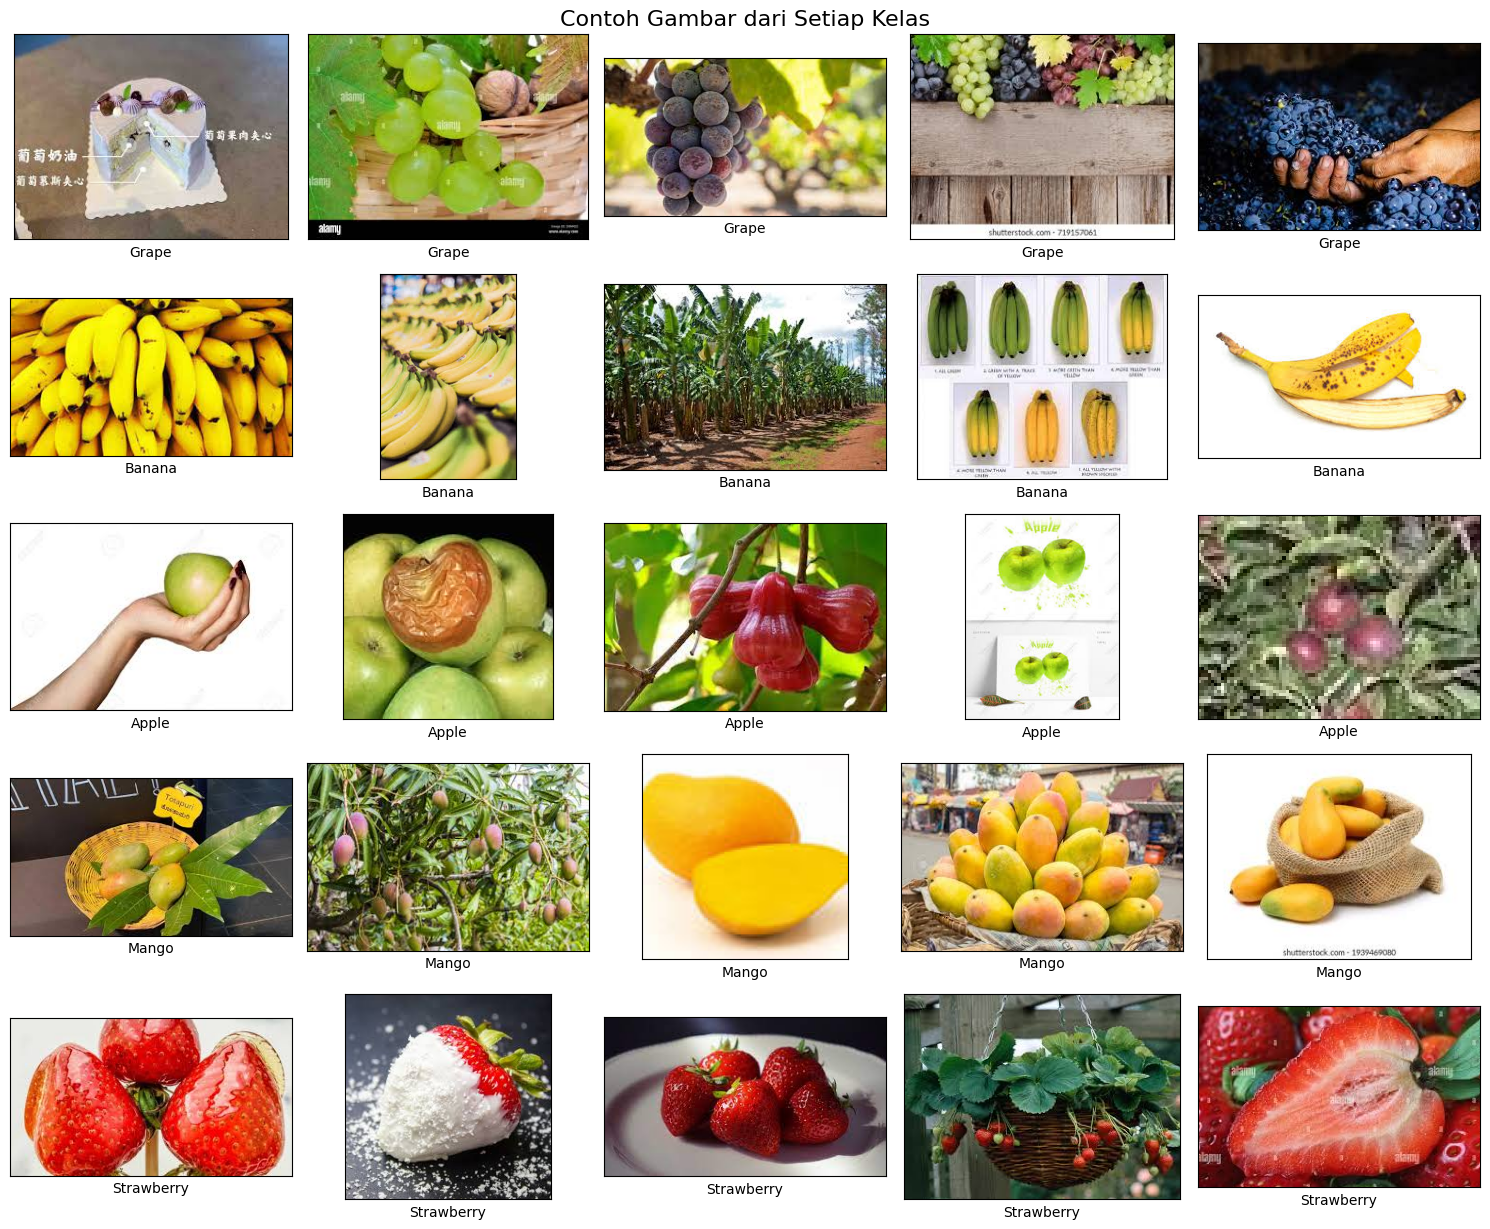

In [7]:
# Membuat kamus yang menyimpan nama file gambar untuk setiap kelas
fruits_image = {}

# Path gabungan dataset
dataset_path = "Fruits Classification/dataset"

# Mengisi kamus dengan file gambar per kelas
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        fruits_image[class_name] = os.listdir(class_dir)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(fruits_image), 5, figsize=(15, len(fruits_image) * 2.5))

for i, class_name in enumerate(fruits_image.keys()):
    # Ambil 5 gambar secara acak
    images = np.random.choice(fruits_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        try:
            img = Image.open(img_path)  # Tetap dalam format warna RGB
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except:
            print(f"Gagal memuat gambar: {img_path}")

fig.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=16)
fig.tight_layout()
plt.show()

### **Plot Distribusi Gambar di Seluruh Kelas**

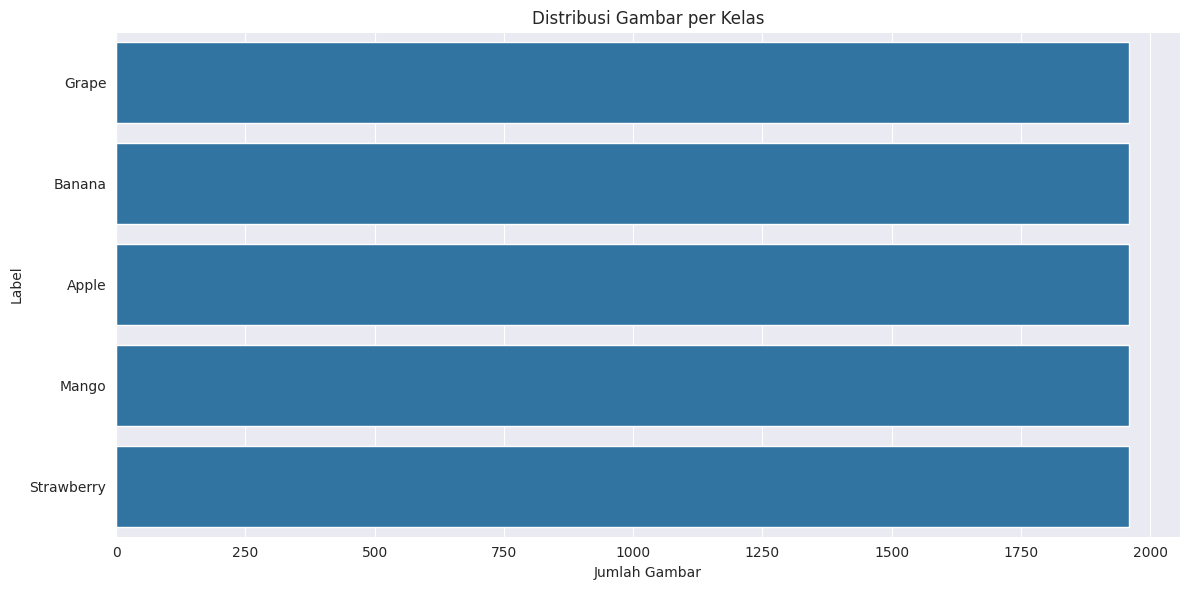

In [8]:
# Path dataset yang sudah digabung
dataset_path = "Fruits Classification/dataset"

# List untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Looping semua file dan simpan ke list
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        if name.endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Buat dataframe
distribution_df = pd.DataFrame({
    "file_name": file_name,
    "path": full_path,
    "labels": labels
})

# Plot distribusi jumlah gambar tiap label
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, y="labels", order=distribution_df["labels"].value_counts().index)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# **Data Splitting**

In [9]:
# Path dataset
mypath = 'Fruits Classification/dataset'

# Variabel penampung
file_name = []
labels = []
full_path = []

# Telusuri semua file gambar
for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Hitung jumlah gambar per label
label_counts = df.groupby(['labels']).size()

# Tampilkan jumlah per label
print("Jumlah gambar per label:\n")
print(label_counts)

# Total keseluruhan gambar
total_images = label_counts.sum()
print(f"\nTotal seluruh gambar: {total_images}")


Jumlah gambar per label:

labels
Apple         1960
Banana        1960
Grape         1960
Mango         1960
Strawberry    1960
dtype: int64

Total seluruh gambar: 9800


In [10]:
# Variabel fitur dan target
X = df['path']
y = df['labels']

# Split dataset menjadi data latih dan data uji (80%:20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Tampilkan jumlah data masing-masing
print(f"Jumlah total gambar: {len(df)}")
print(f"Jumlah data latih : {len(X_train)}")
print(f"Jumlah data uji   : {len(X_test)}")

Jumlah total gambar: 9800
Jumlah data latih : 7840
Jumlah data uji   : 1960


In [11]:
# Menyatukan ke masing-masing dataframe dengan penanda 'set'
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Gabungkan keduanya menjadi satu dataframe
df_combined = pd.concat([df_tr, df_te]).reset_index(drop=True)

# Tampilkan contoh hasil
print(df_combined.head())

# Hitung jumlah data pada masing-masing set dan label
print("\nJumlah data per set:")
print(df_combined['set'].value_counts())

print("\nJumlah data per label di tiap set:")
print(df_combined.groupby(['set', 'labels']).size())

                                                path      labels    set
0  Fruits Classification/dataset/Apple/Apple (191...       Apple  train
1  Fruits Classification/dataset/Strawberry/Straw...  Strawberry  train
2  Fruits Classification/dataset/Mango/Mango (162...       Mango  train
3  Fruits Classification/dataset/Mango/Mango (75)...       Mango  train
4  Fruits Classification/dataset/Grape/Grape (143...       Grape  train

Jumlah data per set:
set
train    7840
test     1960
Name: count, dtype: int64

Jumlah data per label di tiap set:
set    labels    
test   Apple          416
       Banana         368
       Grape          399
       Mango          371
       Strawberry     406
train  Apple         1544
       Banana        1592
       Grape         1561
       Mango         1589
       Strawberry    1554
dtype: int64


In [12]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

# Tampilkan jumlah data per label di masing-masing set
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Tampilkan 5 sampel data secara acak
print(df_all.sample(5))


set    labels    
test   Apple          416
       Banana         368
       Grape          399
       Mango          371
       Strawberry     406
train  Apple         1544
       Banana        1592
       Grape         1561
       Mango         1589
       Strawberry    1554
dtype: int64 


                                                   path      labels    set
6501  Fruits Classification/dataset/Mango/Mango (108...       Mango  train
3178  Fruits Classification/dataset/Banana/Banana (3...      Banana  train
7845  Fruits Classification/dataset/Strawberry/Straw...  Strawberry   test
5346  Fruits Classification/dataset/Mango/Mango (176...       Mango  train
329   Fruits Classification/dataset/Mango/Mango (83)...       Mango  train


In [13]:
# Path asli dan path akhir
datasource_path = "Fruits Classification/dataset"
dataset_path = "Fruits Classification/dataset-final"

In [14]:
# Salin file satu per satu ke direktori tujuan
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']

    # Jika file tidak ditemukan, coba cari ulang berdasarkan struktur aslinya
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'])

    # Buat folder tujuan jika belum ada
    target_folder = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_folder, exist_ok=True)

    # Path tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_folder, destination_file_name)

    # Salin file jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

print("Semua file berhasil disalin ke", dataset_path)

  0%|          | 0/9800 [00:00<?, ?it/s]

Semua file berhasil disalin ke Fruits Classification/dataset-final


# **Data Augmentation**

In [15]:
# Fungsi untuk augmentasi dan resizing dataset
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    # Augmentasi lengkap untuk data latih
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Hanya rescale untuk data test
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, test_generator

# Path ke folder utama
base_path = "Fruits Classification/dataset-final"
train_generator, test_generator = augment_and_resize_dataset(base_path)

Found 7840 images belonging to 5 classes.
Found 1960 images belonging to 5 classes.


In [16]:
# Menampilkan class indices
class_indices = train_generator.class_indices
print(class_indices)

{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}


# **Modelling**

In [17]:
# Load pre-trained MobileNetV2 tanpa top layer dan freeze semua layer-nya
pre_trained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
pre_trained_model.trainable = False

# Buat model Sequential
model = Sequential()

# Tambahkan base MobileNetV2
model.add(pre_trained_model)

# Tambahkan 1 lapis Conv2D dan MaxPooling2D saja
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Gunakan GlobalAveragePooling2D alih-alih Flatten
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Ubah sesuai jumlah kelas

# Tampilkan ringkasan model
model.summary()

<ipython-input-17-1ffd833dd2df>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,293 (11.46 MB)

 Trainable params: 746,309 (2.85 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# Compile model dengan optimizer Adam dan learning rate kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Menghitung class weight untuk dataset yang tidak seimbang
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [20]:
# Callback untuk menyimpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Callback kustom: berhenti jika val_accuracy >= 0.96
class StopAtValAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy", 0) >= 0.96:
            print(f"\nTraining dihentikan: val_accuracy mencapai {logs['val_accuracy']:.4f} pada epoch {epoch+1}")
            self.model.stop_training = True

In [21]:
# Training model dengan class_weight dan callback
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[checkpoint, StopAtValAccuracy()],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 68s 233ms/step - accuracy: 0.4989 - loss: 1.2862 - val_accuracy: 0.8015 - val_loss: 0.5656
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.7397 - loss: 0.7219 - val_accuracy: 0.8102 - val_loss: 0.5341
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.7608 - loss: 0.6282 - val_accuracy: 0.8311 - val_loss: 0.4748
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.7980 - loss: 0.5723 - val_accuracy: 0.8352 - val_loss: 0.4612
Epoch 5/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step - accuracy: 0.7994 - loss: 0.5506 - val_accuracy: 0.8423 - val_loss: 0.4447
Epoch 6/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.8034 - loss: 0.5261 - val_accuracy: 0.8474 - val_loss: 0.4315
Epoch 7/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.8319 - loss: 0.4679 - val_accuracy: 0.8474 - val_loss: 0.4204
Epoch 8/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.8244 - loss: 0

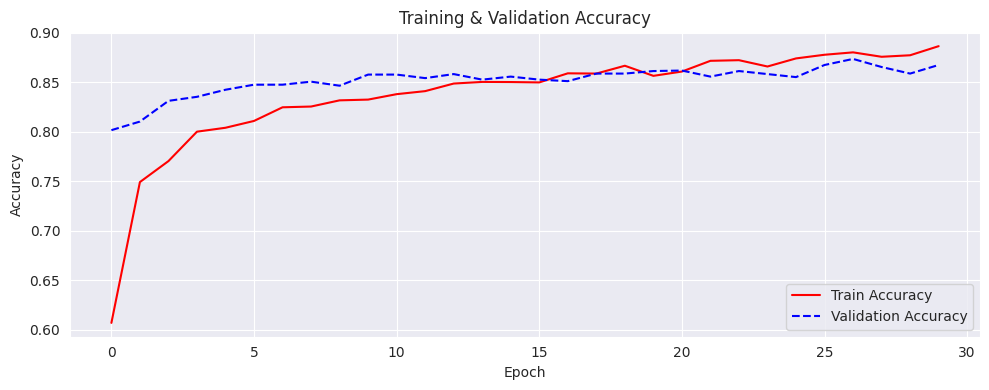

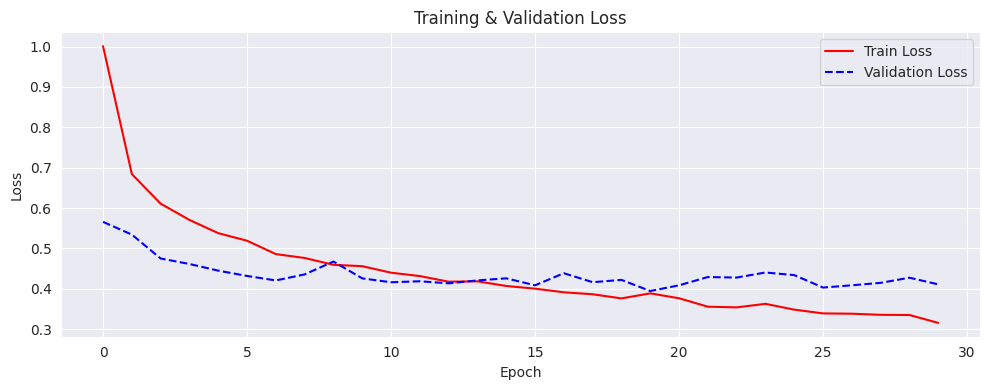

In [22]:
# Ambil metrik dari hasil training
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(10, 4))
plt.plot(epochs, acc, 'r-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss, 'r-', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

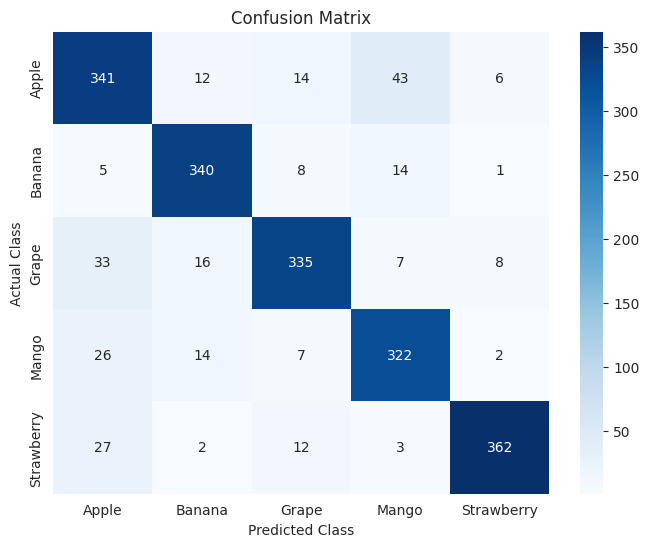


Classification Report:

              precision    recall  f1-score   support

       Apple     0.7894    0.8197    0.8042       416
      Banana     0.8854    0.9239    0.9043       368
       Grape     0.8910    0.8396    0.8645       399
       Mango     0.8278    0.8679    0.8474       371
  Strawberry     0.9551    0.8916    0.9223       406

    accuracy                         0.8673      1960
   macro avg     0.8697    0.8686    0.8685      1960
weighted avg     0.8697    0.8673    0.8679      1960



In [23]:
# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi menggunakan model
preds_final = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(preds_final, axis=1)

# Membuat confusion matrix
class_labels = list(train_generator.class_indices.keys())
cm = confusion_matrix(test_generator.classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Tampilkan classification report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=predicted_classes,
    target_names=class_labels,
    digits=4
))

# **Konversi Model**

### **Konversi TFJS**

In [35]:
model.save("model.h5")

In [36]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-17 13:45:28.126331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744897528.147127   13219 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744897528.153333   13219 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


### **Konversi SavedModel**

In [28]:
save_path = os.path.join("saved_model")
tf.saved_model.save(model, save_path)

### **Konversi TF-Lite**

In [38]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [31]:
# Ambil label dari train_generator
class_indices = train_generator.class_indices

# Urutkan label berdasarkan indeks (karena dictionary bisa tidak urut)
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])
label_list = [label for label, index in sorted_labels]

# Gabungkan menjadi satu string dengan newline
content = "\n".join(label_list)

# Tentukan path dan nama file
file_path = "label.txt"

# Tulis ke dalam file
with open(file_path, "w") as file:
    file.write(content)

print("Label berhasil disimpan ke:", file_path)

Label berhasil disimpan ke: label.txt


In [39]:
!pip freeze > requirements.txt

# **Inference**

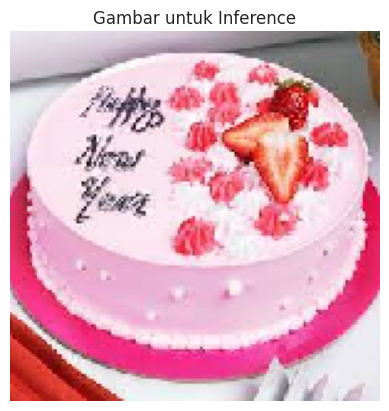

In [32]:
# Ukuran gambar harus sama dengan input model: 150x150
img_path = 'Fruits Classification/dataset/Strawberry/Strawberry (100).jpeg'

img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Visualisasi gambar yang di-inference
plt.imshow(img)
plt.axis("off")
plt.title("Gambar untuk Inference")
plt.show()

In [33]:
# Load model
loaded_model = tf.keras.models.load_model('best_model.keras')

# Prediksi
predictions = loaded_model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Kelas asli dari model
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class_index]

print("Kelas yang diprediksi:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Kelas yang diprediksi: Strawberry
